Se importan las librerias 

In [266]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from numpy import fft
import math as mt

#def THD (RMS):
#    THDi= (np.sum(RMS[2:]))/RMS[1]
#
#    return THDi


def THD(RMS, RMST):

    THDi= (np.sqrt(RMST**2 - RMS[1]**2))/(RMS[1])

    return THDi

def filtro_pasabajas_ideal(signal, time, fc):
    # Calcula la transformada de Fourier de la señal
    fourier = np.fft.fft(signal)
    
    # Crea el vector de frecuencias
    freq = np.fft.fftfreq(len(signal), d=time[1] - time[0])
    
    # Aplica el filtro pasabajas ideal
    fourier_filt = fourier.copy()
    fourier_filt[np.abs(freq) > fc] = 0
    
    # Calcula la transformada inversa de Fourier
    signal_filt = np.fft.ifft(fourier_filt)
    
    return np.real(signal_filt)

def Armonicos (señal, tiempo, n):
    #T=len(tiempo)
    #T=tiempo[-1]
    T=len(tiempo)
    an=0
    bn=0
    a0=0
    for i in range (0,T,1):
        a0+=(1/T) * señal[i]
        an+=(2/T) * señal[i]*np.cos(n*2*np.pi*60*tiempo[i])
        bn+=(2/T) * señal[i]*np.sin(n*2*np.pi*60*tiempo[i])
    An=np.sqrt((an**2)+(bn**2))
    theta_n=np.arctan(bn/an)
    gamma_n=np.arctan(an/bn)
    return An, theta_n, gamma_n, a0, an, bn

##Para obtener los datos de los puntos organizados
def get_oscilloscope(ruta):
    Dataframe=pd.read_csv(ruta)
    Dataframe=Dataframe.iloc[:, 3:5] 
    Dataframe.columns=["Tiempo", "Magnitud"]
    return Dataframe 
 
def buscaarmonicos(magnitud, tiempo):
    n=50
    armonicos=np.zeros(n)
    thetas= np.zeros(n)
    gammas=np.zeros(n)
    an=np.zeros(n)
    bn=np.zeros(n)
    RMS=np.zeros(n)
    ft=0
    maxt=0
    for j in range(1,n,1):
        armonicos[j] ,thetas[j], gammas[j], a0, an[j], bn[j]  =Armonicos(magnitud,tiempo,j)
        #ft+=armonicos[j]*np.cos(j*2*np.pi*60*tiempo-thetas[j])

        #SE HIZO CON LA OTRA FORMULA, REVISAR AN
        RMS[j]=np.sqrt(np.mean(np.square(an[j]*np.cos(j*2*np.pi*60*tiempo)+bn[j]*np.sin(j*2*np.pi*60*tiempo))))
        
        # Rms integraaaaaal
        #RMS[j]=rmspalosmachos(an[j]*np.cos(j*2*np.pi*60*tiempo)+bn[j]*np.sin(j*2*np.pi*60*tiempo), tiempo)

        ft+=an[j]*np.cos(j*2*np.pi*60*tiempo)+bn[j]*np.sin(j*2*np.pi*60*tiempo)
        maxt+=max(an[j]*np.cos(j*2*np.pi*60*tiempo)+bn[j]*np.sin(j*2*np.pi*60*tiempo))

        #ft+=((an[j]**2 +bn[j]**2)**(1/2))*np.sin((j*2*np.pi*60*tiempo )- mt.atan(an[j]/(-bn[j])))
        #ft+=(an[j]+bn[j])*np.sin(j*2*np.pi*60*tiempo - (np.pi/4))
 
    RMS[0]=a0
    RMS_ARMONICOS=RMS    
    ft=ft+a0
    return ft, armonicos , RMS_ARMONICOS 

def rmspalosmachos(fun,tiempo):
    #T=tiempo.iloc[-1]
    T=len(tiempo)
    #deltat=tiempo[1]-tiempo[0]   
    frms=0
    for i in range(len(tiempo)):
        frms+=(1/T)*((fun[i]**2))
    frms=np.sqrt((frms))
    return frms
    
def nohagastrampa(fun,tiempo):
    T=len(tiempo)
    Prom=0
    for i in range(T):
        Prom+=fun[i]
    Prom=Prom/T
    return Prom

Carga inductiva

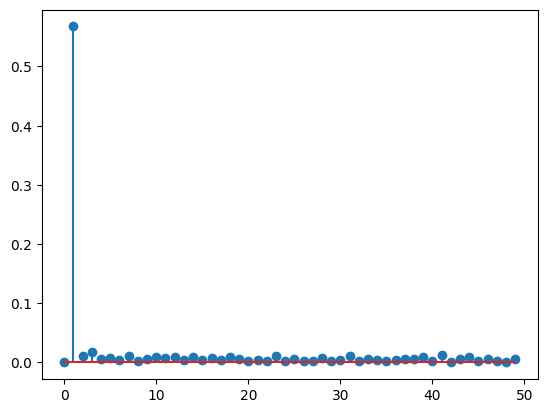

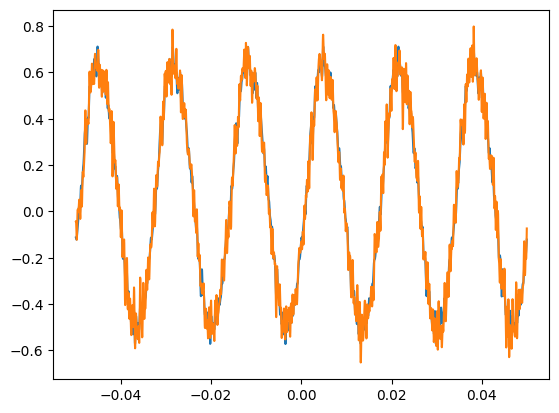

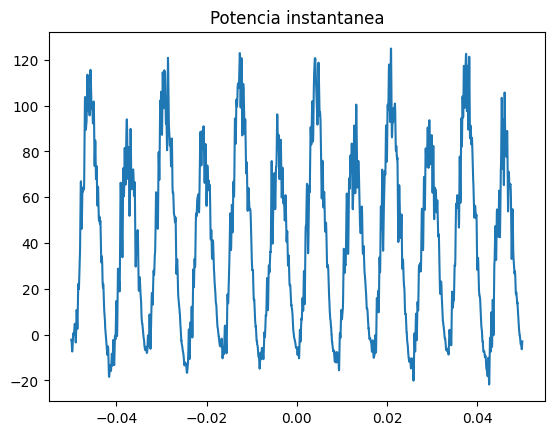

Distorsion armonica total 0.18275631208383994
-------------------------------
RMS integral 0.40807941115247337
RMS segun el cachón 0.40807941115247315
Rms con np.sum only for pussys 0.40806295407663845
-------------------------------

La potencia promedio del PC es 40.79534813910406 W
-------------------------------
La potencia aparente del PC es 50.790786475116036 VA
-------------------------------
El factor de rizado de voltaje es de  1.4389936753036165 y de corriente 1.9447687935776352
El factor de forma de voltaje es de  1.0850662762242411 y de corriente 1.3707417418730379
-------------------------------
la potencia reactiva del sistema es 28.667009090110916 VAR

El factor de potencia es 0.8032037101668222
El factor de desplazamiento DPF 0.8165069901629944
El factor de distorsion DP 0.9837070837648108
el THD es de 0.18275631208383994 de corriente del Abanico
-------------------------------
la potencia armonica del sistema es 9.677094129831916 VA
-------------------------------
114.

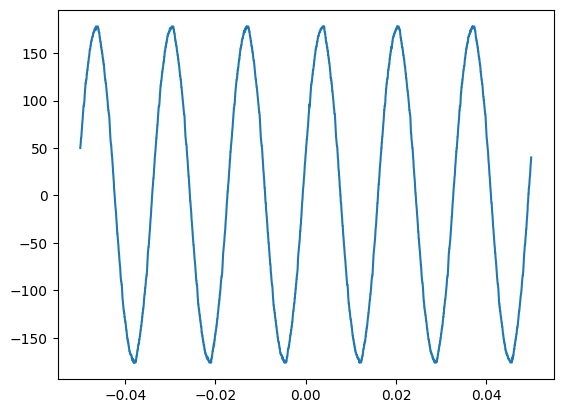

In [263]:
CH1=get_oscilloscope("abanico/CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("abanico/CH2.CSV")
R=10.4
CURRENT=(CH1.Magnitud-CH2.Magnitud)/R
#CURRENT=(CH1.Magnitud)
CURRENT=filtro_pasabajas_ideal(CURRENT, CH1.Tiempo.to_numpy(),3500)
ACTIVE_POWER=CURRENT*CH1.Magnitud



##Componentes armonicos
ft, armonicos, RMS_Armonicos =buscaarmonicos(CURRENT, CH1.Tiempo)

plt.stem(armonicos)
plt.show()
plt.plot(CH1.Tiempo,ft)
plt.plot(CH1.Tiempo,CURRENT)
plt.show()

plt.plot(CH1.Tiempo, CH1.Magnitud*CURRENT)
plt.title("Potencia instantanea")
plt.show()

THDi=THD(RMS_Armonicos,(np.sqrt(np.sum(RMS_Armonicos**2))))
print("Distorsion armonica total "+ str(THDi))

print("-------------------------------")
rmsinte=rmspalosmachos(ft, CH1.Tiempo)
print("RMS integral "+ str(rmsinte))
#print("RMS segun el cachón "+str(np.sum(RMS_Armonicos)))
print("RMS segun el cachón "+str(np.sqrt(np.mean(np.square(ft)))))
print("Rms con np.sum only for pussys "+str(np.sqrt(np.sum(RMS_Armonicos**2))))

print("-------------------------------")
p_ave = np.mean(CH1.Magnitud*CURRENT)
print('')

print(f'La potencia promedio del PC es {p_ave} W')
print("-------------------------------")
v_RMS = np.sqrt(np.mean(np.square(CH1.Magnitud)))
CURRENT_RMS=np.sqrt(np.mean(np.square(CURRENT)))
S_aparente =  CURRENT_RMS*v_RMS
print(f'La potencia aparente del PC es {S_aparente} VA')

print("-------------------------------")

#tabuscar=1/60
positionmid=np.searchsorted(ft,CURRENT_RMS*(np.sqrt(2)))
CF_v, CF_i = max(CH1.Magnitud)/v_RMS,max(CURRENT)/CURRENT_RMS
FF_v, FF_i = v_RMS/((CH1.Magnitud[0]+max(CH1.Magnitud))/2), CURRENT_RMS/((ft[0]+max(ft))/2)

print(f'El factor de rizado de voltaje es de  {CF_v} y de corriente {CF_i}')
print(f'El factor de forma de voltaje es de  {FF_v} y de corriente {FF_i}')

print("-------------------------------")

DP = 1/np.sqrt(1+(THDi**2))
FP = p_ave/S_aparente
phi = np.arccos(FP/DP)
Q = v_RMS*RMS_Armonicos[1]*np.sin(phi)

print(f'la potencia reactiva del sistema es {Q} VAR')
print('')
print(f'El factor de potencia es {FP}')
print(f'El factor de desplazamiento DPF {FP/DP}')
print(f'El factor de distorsion DP {DP}')
print(f'el THD es de {THDi} de corriente del Abanico')

print("-------------------------------")

D = np.sqrt((S_aparente**2)-(p_ave**2)-(Q**2))

print(f'la potencia armonica del sistema es {D} VA')
#print("Maximo" str(max))
#np.sqrt(np.mean(np.square(

print("-------------------------------")

plt.plot(CH1.Tiempo, CH1.Magnitud)

print(((CH1.Magnitud[0]+max(CH1.Magnitud))/2), v_RMS)


## Carga no lineal

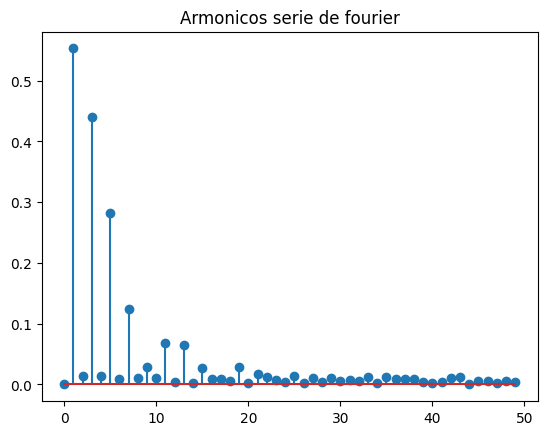

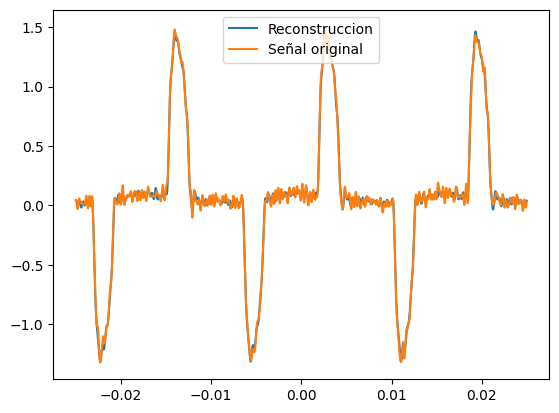

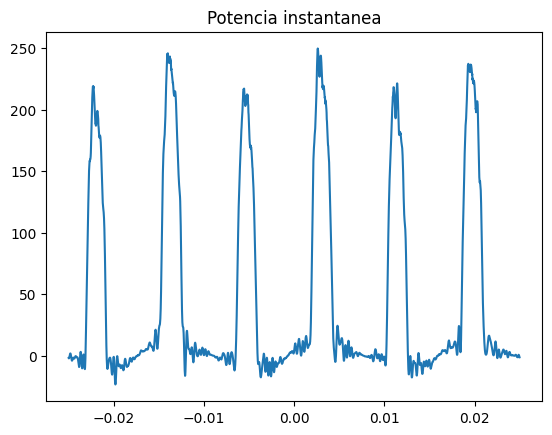

Distorsion armonica total 1.0113544339030736
-------------------------------
RMS integral 0.5561558630462259
RMS segun el cachón 0.5561558630462262
Rms con np.sum only for pussys 0.5560436579941815
-------------------------------

La potencia promedio del PC es 47.079517400473726 W
-------------------------------
La potencia aparente del PC es 69.12185278162954 VA
-------------------------------
El factor de rizado de voltaje es de  1.4498488601009383 y de corriente 2.702620568866948
El factor de forma de voltaje es de  1.0986802816614982 y de corriente 0.7389931621190245
-------------------------------
la potencia reactiva del sistema es 12.045375038112509 VAR

El factor de potencia es 0.6811090198812786
El factor de desplazamiento DPF 0.9687175347078391
El factor de distorsion DP 0.7031038413965512
el THD es de 1.0113544339030736 de corriente del Abanico
-------------------------------
la potencia armonica del sistema es 49.15545253067024 VA
-------------------------------


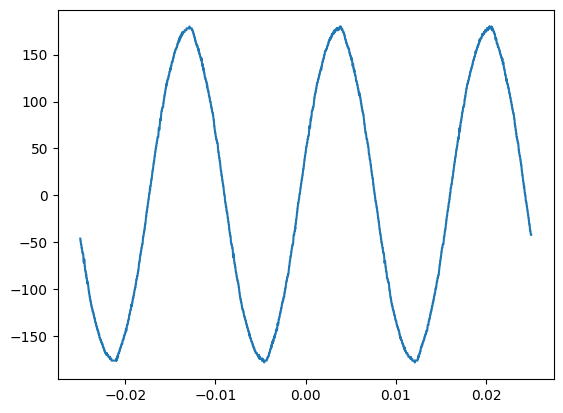

In [264]:
CH1=get_oscilloscope("PC\ALL0001\F0001CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("PC\ALL0001\F0001CH2.CSV")

R=10.4
CURRENT=(CH1.Magnitud-CH2.Magnitud)/R

CURRENT=filtro_pasabajas_ideal(CURRENT, CH1.Tiempo.to_numpy(),3500)
ACTIVE_POWER=CURRENT*CH1.Magnitud

####

VRMS=np.sqrt(np.mean(np.square(CH1.Magnitud)))

ft, armonicos,RMS_Armonicos =buscaarmonicos(CURRENT, CH1.Tiempo)

plt.stem(armonicos)
plt.title("Armonicos serie de fourier")
plt.show()
plt.plot(CH1.Tiempo,ft, label="Reconstruccion")
plt.plot(CH1.Tiempo,CURRENT, label="Señal original")
plt.legend()
plt.show()


plt.plot(CH1.Tiempo, CH1.Magnitud*CURRENT)
plt.title("Potencia instantanea")
plt.show()


THDi=THD(RMS_Armonicos,(np.sqrt(np.sum(RMS_Armonicos**2))))
print("Distorsion armonica total "+ str(THDi))

print("-------------------------------")
rmsinte=rmspalosmachos(ft, CH1.Tiempo)
print("RMS integral "+ str(rmsinte))
#print("RMS segun el cachón "+str(np.sum(RMS_Armonicos)))
print("RMS segun el cachón "+str(np.sqrt(np.mean(np.square(ft)))))
print("Rms con np.sum only for pussys "+str(np.sqrt(np.sum(RMS_Armonicos**2))))

print("-------------------------------")
p_ave = np.mean(CH1.Magnitud*CURRENT)
print('')

print(f'La potencia promedio del PC es {p_ave} W')
print("-------------------------------")
v_RMS = np.sqrt(np.mean(np.square(CH1.Magnitud)))
CURRENT_RMS=np.sqrt(np.mean(np.square(CURRENT)))
S_aparente =  CURRENT_RMS*v_RMS
print(f'La potencia aparente del PC es {S_aparente} VA')

print("-------------------------------")

#tabuscar=1/60
positionmid=np.searchsorted(ft,CURRENT_RMS*(np.sqrt(2)))
CF_v, CF_i = max(CH1.Magnitud)/v_RMS,max(CURRENT)/CURRENT_RMS
FF_v, FF_i = v_RMS/((abs(CH1.Magnitud[0])+max(CH1.Magnitud))/2), CURRENT_RMS/((ft[0]+max(ft))/2)

print(f'El factor de rizado de voltaje es de  {CF_v} y de corriente {CF_i}')
print(f'El factor de forma de voltaje es de  {FF_v} y de corriente {FF_i}')

print("-------------------------------")

DP = 1/np.sqrt(1+(THDi**2))
FP = p_ave/S_aparente
phi = np.arccos(FP/DP)
Q = v_RMS*RMS_Armonicos[1]*np.sin(phi)

print(f'la potencia reactiva del sistema es {Q} VAR')
print('')
print(f'El factor de potencia es {FP}')
print(f'El factor de desplazamiento DPF {FP/DP}')
print(f'El factor de distorsion DP {DP}')
print(f'el THD es de {THDi} de corriente del Abanico')

print("-------------------------------")

D = np.sqrt((S_aparente**2)-(p_ave**2)-(Q**2))

print(f'la potencia armonica del sistema es {D} VA')


print("-------------------------------")

plt.plot(CH1.Tiempo, CH1.Magnitud)



#

CARGA RESISTIVA

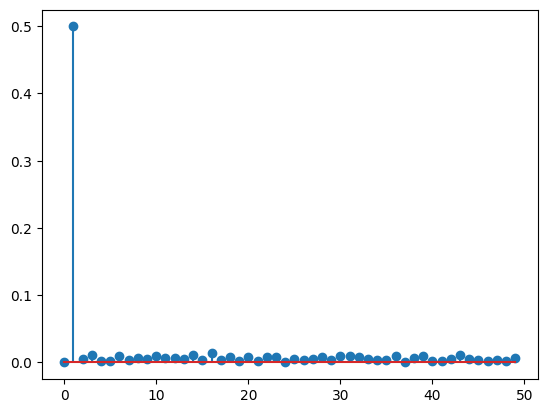

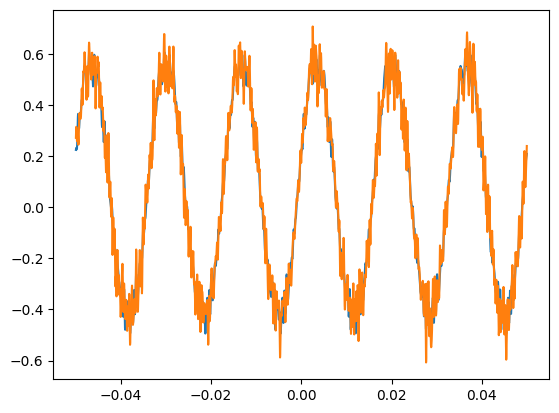

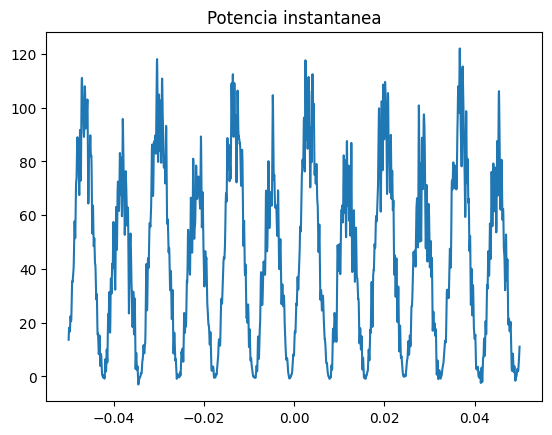

Distorsion armonica total 0.2082013738328888
-------------------------------
RMS integral 0.3608839963834127
RMS segun el cachón 0.3608839963834126
Rms con np.sum only for pussys 0.3608959103399738
-------------------------------

La potencia promedio del PC es 44.023916413418 W
-------------------------------
La potencia aparente del PC es 45.3198663809919 VA
-------------------------------
El factor de rizado de voltaje es de  1.4457363434231356 y de corriente 1.9470058068090121
El factor de forma de voltaje es de  1.0826437326727996 y de corriente 0.9781164734411721
-------------------------------
la potencia reactiva del sistema es 5.471262551284172 VAR

El factor de potencia es 0.9714043735990041
El factor de desplazamiento DPF 0.9922351532614495
El factor de distorsion DP 0.9790062067505115
el THD es de 0.2082013738328888 de corriente del Abanico
-------------------------------
la potencia armonica del sistema es 9.265546854355653 VA
-------------------------------
0.364003210589

In [268]:
CH1=get_oscilloscope("cautin\F0000CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("cautin\F0000CH2.CSV")

R=10.4
CURRENT=(CH1.Magnitud-CH2.Magnitud)/R

ACTIVE_POWER=CURRENT*CH1.Magnitud
CURRENT=filtro_pasabajas_ideal(CURRENT, CH1.Tiempo.to_numpy(),3500)
##Componentes armonicos


ft, armonicos,RMS_Armonicos =buscaarmonicos(CURRENT, CH1.Tiempo)
plt.stem(armonicos)
plt.show()
plt.plot(CH1.Tiempo,ft)
plt.plot(CH1.Tiempo,CURRENT)
plt.show()

plt.plot(CH1.Tiempo, CH1.Magnitud*CURRENT)
plt.title("Potencia instantanea")
plt.show()


THDi=THD(RMS_Armonicos,(np.sqrt(np.sum(RMS_Armonicos**2))))
print("Distorsion armonica total "+ str(THDi))



print("-------------------------------")
rmsinte=rmspalosmachos(ft, CH1.Tiempo)
print("RMS integral "+ str(rmsinte))
#print("RMS segun el cachón "+str(np.sum(RMS_Armonicos)))
print("RMS segun el cachón "+str(np.sqrt(np.mean(np.square(ft)))))
print("Rms con np.sum only for pussys "+str(np.sqrt(np.sum(RMS_Armonicos**2))))

print("-------------------------------")
p_ave = np.mean(CH1.Magnitud*CURRENT)
print('')

print(f'La potencia promedio del PC es {p_ave} W')
print("-------------------------------")
v_RMS = np.sqrt(np.mean(np.square(CH1.Magnitud)))
CURRENT_RMS=np.sqrt(np.mean(np.square(CURRENT)))
S_aparente =  CURRENT_RMS*v_RMS
print(f'La potencia aparente del PC es {S_aparente} VA')

print("-------------------------------")

#tabuscar=1/60
positionmid=np.searchsorted(ft,CURRENT_RMS*(np.sqrt(2)))
CF_v, CF_i = max(CH1.Magnitud)/v_RMS,max(CURRENT)/CURRENT_RMS
largotiempo=len(CH1.Tiempo)
nuevovectorp=CH1.Tiempo[:round((largotiempo/12))]
pruebarms=nohagastrampa(ft,nuevovectorp)
FF_v, FF_i = v_RMS/((CH1.Magnitud[0]+max(CH1.Magnitud))/2), CURRENT_RMS/(pruebarms)

print(f'El factor de rizado de voltaje es de  {CF_v} y de corriente {CF_i}')
print(f'El factor de forma de voltaje es de  {FF_v} y de corriente {FF_i}')

print("-------------------------------")

DP = 1/np.sqrt(1+(THDi**2))
FP = p_ave/S_aparente
phi = np.arccos(FP/DP)
Q = v_RMS*RMS_Armonicos[1]*np.sin(phi)

print(f'la potencia reactiva del sistema es {Q} VAR')
print('')
print(f'El factor de potencia es {FP}')
print(f'El factor de desplazamiento DPF {FP/DP}')
print(f'El factor de distorsion DP {DP}')
print(f'el THD es de {THDi} de corriente del Abanico')

print("-------------------------------")

D = np.sqrt((S_aparente**2)-(p_ave**2)-(Q**2))

print(f'la potencia armonica del sistema es {D} VA')

print("-------------------------------")
print(CURRENT_RMS ,((ft[0]+max(ft))), pruebarms)